In [1]:
#import the important libaries
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from agent_navigation import Agent
import time
import random

/home/osboxes/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370193460/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#definition hyperparameters and trainingsconditions
max_episodes = 20
max_timestaps = 1000
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
training_mode = True
gamma = 0.99

#environment parameters
state_size = 37
action_size = 4
seed = 0

In [3]:
#define the environment
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

#get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#get number of possible actions
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 20	Average Score: 0.157

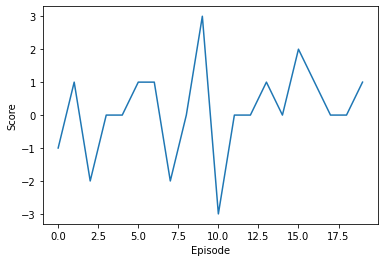

In [4]:
#define an agent
agent = Agent(state_size, action_size, seed)

#counter to print envirement sloved only once
counter = 0

#train the agent
def dqn_train(n_episodes, max_t, eps_start, eps_end, eps_decay):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #list containing scores from each episode
    scores = []
    #last 100 scores
    scores_window = deque(maxlen=100)
    #initialize epsilon
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        global counter
        #reset the environment
        env_info = env.reset(train_mode=training_mode)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            #select an action
            action = agent.act(state)
            #send the action to the environment
            env_info = env.step(action)[brain_name]  
            #get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            #see if episode has finished
            done = env_info.local_done[0]
            #save step in memory and learn from this step
            agent.step(state, action, reward, next_state, done)
            #update the score
            score += reward
            #roll over the state to next time step
            state = next_state
            # exit loop if episode finished
            if done:
                break
        #save most recent score
        scores_window.append(score)
        #save most recent score
        scores.append(score)
        #decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13 and counter == 0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            counter = 1
    return scores
            
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
scores = dqn_train(max_episodes, max_timestaps, max_epsilon, min_epsilon, epsilon_decay)

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [10]:
from model import QNetwork
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(agent.qnetwork_local.state_dict().keys())
print(agent)
for param in agent.qnetwork_local.parameters():
    print(param.data)

state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())
trained_model = QNetwork(state_size, action_size, seed).to(device)
trained_model.load_state_dict(state_dict)
trained_model.eval()
agent2 = Agent(state_size, action_size, seed)
agent2.qnetwork_local = trained_model
print(agent2)
for param in agent2.qnetwork_local.parameters():
    print(param.data)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
tensor([[-0.0343,  0.1388, -0.0890,  ..., -0.1299, -0.1548, -0.0797],
        [ 0.1778,  0.0530, -0.0277,  ..., -0.2201,  0.1098,  0.1077],
        [ 0.1611,  0.1695,  0.0960,  ..., -0.0014,  0.0614, -0.0681],
        ...,
        [-0.0379, -0.0704,  0.0902,  ..., -0.1209,  0.0499,  0.0139],
        [ 0.0560, -0.0138,  0.0157,  ..., -0.0067,  0.1132,  0.0319],
        [-0.0925, -0.0874, -0.1608,  ..., -0.0375, -0.0084,  0.0080]])
tensor([ 0.1479, -0.0390, -0.1325, -0.0605,  0.1320, -0.0390, -0.0808,  0.0644,
         0.0140, -0.1326,  0.1218,  0.0546,  0.1402,  0.0778, -0.0541, -0.0659,
         0.0630, -0.0694,  0.0283, -0.1834, -0.1361,  0.0399, -0.0197, -0.0983,
        -0.1667,  0.1125, -0.0277, -0.1743,  0.1477,  0.0757, -0.0889, -0.1436,
         0.1477, -0.0227, -0.0866,  0.0775, -0.0215, -0.0136, -0.0904, -0.1312,
        -0.1091, -0.0499, -0.1567,  0.1710,  0.0123, -0.0592,  0.0582, -0.1

Episode 10	Average Score: 0.10

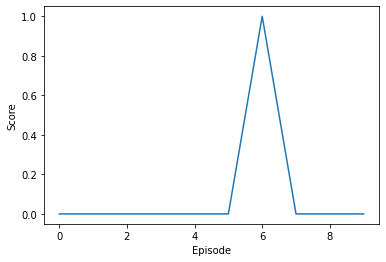

In [6]:
#use agent2
def dqn_train(n_episodes, max_t, eps_start, eps_end, eps_decay):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #list containing scores from each episode
    scores = []
    #last 100 scores
    scores_window = deque(maxlen=100)
    #initialize epsilon
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        global counter
        #reset the environment
        env_info = env.reset(train_mode=training_mode)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            #select an action
            action = agent2.act(state)
            #send the action to the environment
            env_info = env.step(action)[brain_name]  
            #get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            #see if episode has finished
            done = env_info.local_done[0]
            #save step in memory and learn from this step
            #agent2.step(state, action, reward, next_state, done)
            #update the score
            score += reward
            #roll over the state to next time step
            state = next_state
            # exit loop if episode finished
            if done:
                break
        #save most recent score
        scores_window.append(score)
        #save most recent score
        scores.append(score)
        #decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13 and counter == 0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            counter = 1
    return scores
            
scores = dqn_train(10, max_timestaps, max_epsilon, min_epsilon, epsilon_decay)

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [7]:
#close the environment
env.close()